# CIFAR 10 Image Classification

In this notebook, I am using the CIFAR 10 dataset to train a CNN model to classify images into one of 10 classes:
1. airplane
2. automobile
3. bird
4. cat
5. deer
6. dog
7. frog
8. horse
9. ship
10. truck

Link to the dataset: https://www.cs.toronto.edu/~kriz/cifar.html 

I will be training the model using pytorch.

In [40]:
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,random_split
from matplotlib import pyplot
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch import optim
import pandas as pd
from torch.utils.data import Subset

### Load Dataset
We load the dataset using torchvision, and split it into train and test sets

#### Data Transform
In order to obtain better results we have to perform the following transforms:
1. **Random Crop**: Randomly cropping images in the training set to improve generalization. This makes it so that the objects we are detecting may sometimes not be fully visible in the image, and the model learns to deal with this.
2. **Horizontal Flip**: Flipping some images horizontally, again to make training more robust.  
3. **Normalization**: Transforming features into the same scale. Improves accuracy, and promotes fater convergence during gradient-descent based techniques. Mitigates vanishing or exploding gradients.  

In [16]:
# Calculating Mean and SD for normalization.
dataset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transforms.ToTensor()
)

mean = torch.zeros(3)
std = torch.zeros(3)

for img, _ in dataset:
    mean += img.mean(dim=(1, 2))
    std += img.std(dim=(1, 2))

mean /= len(dataset)
std /= len(dataset)

print(mean, std)

tensor([0.4914, 0.4822, 0.4465]) tensor([0.2023, 0.1994, 0.2010])


In [18]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mean,
        std=std
    )
])

train_dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

In [19]:
classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

### Visualizing the Images
We visualize the first 5 images of the dataset, which are 32x32 colored images.

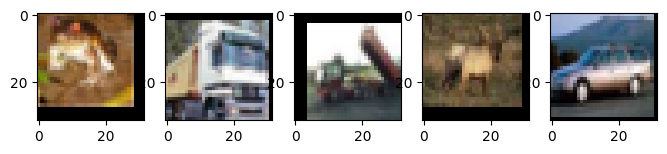

In [21]:
fig, axes = pyplot.subplots(1,5,figsize=(8,3))
for i in range(len(axes)):
    img = train_dataset[i][0].permute(1, 2, 0)  # C×H×W → H×W×C
    img = img * std + mean               # un-normalize
    img = np.clip(img, 0, 1) 
    axes[i].imshow(img, cmap="gray")

### Split into Validation Set
Creating a validation set in order to fine tune the model.

In [5]:
len(train_dataset),len(test_dataset)

(50000, 10000)

In [6]:
full_dataset = train_dataset  # e.g. CIFAR10(train=True)

# Split sizes
val_ratio = 0.1
val_size = int(len(full_dataset) * val_ratio)
train_size = len(full_dataset) - val_size

# Split
train_ds, val_ds = random_split(
    full_dataset,
    [train_size, val_size]
)

In [7]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### EDA

Checking for Class imbalance

In [8]:
labels = np.array([label for __, label in train_dataset])

In [9]:
np.bincount(labels)

array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000])

No class imbalance, train data has equal datapoints for each class

In [10]:
labels_val = np.array([label for __, label in test_dataset])
np.bincount(labels_val)

array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

### Defining base Model

In [8]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x): # creating view layer that reshapes image matrix     
    return x.view(-1, 3, 32, 32)

In [30]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        # print(loss)
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        # print(losses,nums)
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums) # Average batch wise validation loss

        # Early Stopping
        # if val_loss > best_val_loss:
        #     patience_counter += 1   
        print(epoch, val_loss)

In [10]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

In [22]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Lambda-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 16, 16]             448
              ReLU-3           [-1, 16, 16, 16]               0
            Conv2d-4             [-1, 16, 8, 8]           2,320
              ReLU-5             [-1, 16, 8, 8]               0
            Conv2d-6             [-1, 10, 4, 4]           1,450
              ReLU-7             [-1, 10, 4, 4]               0
         AvgPool2d-8             [-1, 10, 1, 1]               0
            Lambda-9                   [-1, 10]               0
Total params: 4,218
Trainable params: 4,218
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 0.02
Estimated Total Size (MB): 0.13
-----------------------------------------------

In [ ]:
lr = 0.1
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_func = F.cross_entropy

fit(10, model, loss_func, opt, train_loader, val_loader)

0 1.9454066368103027
1 1.7650541831970215
2 1.6894147998809814
3 1.6395266544342042
4 1.6009808971405028
5 1.5641614751815796
6 1.5562296747207642
7 1.5112775846481323
8 1.4938481004714965
9 1.5074470615386963


In [28]:
model(train_dataset[0][0])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<ViewBackward0>)

In [36]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

def print_accuracy(model, train_loader, val_loader):
    accuracies = [accuracy(model(xb), yb) for xb, yb in train_loader]
    print("Train accuracy: ",sum(accuracies)/len(accuracies))
    accuracies = [accuracy(model(xb), yb) for xb, yb in val_loader]
    print("Validation Accuracy: ", sum(accuracies)/len(accuracies))

In [ ]:
print_accuracy(model, train_loader, val_loader)

tensor(0.4595)

Train accuracy and validation accuracy both low. So this might be underfitting.

### Fine Tuning Model Structure
- Reducing lr to 0.01 and adding label smoothing to cross entropy increased accuracy from 0.43 to 0.52
- Adding Data Tranformation and Batch Norm significantly improved accuracy to 0.63 (val) and 0.72 (train). Now the model seems to be overfitting.

**Batch Normalization**: Normalizes the activations after each convolution.

In [31]:
model_tuned = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 10, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.AvgPool2d(2),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

In [32]:
from torchsummary import summary
summary(model_tuned,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Lambda-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 16, 16]             448
       BatchNorm2d-3           [-1, 16, 16, 16]              32
              ReLU-4           [-1, 16, 16, 16]               0
            Conv2d-5             [-1, 32, 8, 8]           4,640
       BatchNorm2d-6             [-1, 32, 8, 8]              64
              ReLU-7             [-1, 32, 8, 8]               0
            Conv2d-8             [-1, 64, 4, 4]          18,496
       BatchNorm2d-9             [-1, 64, 4, 4]             128
             ReLU-10             [-1, 64, 4, 4]               0
           Conv2d-11             [-1, 10, 2, 2]           5,770
      BatchNorm2d-12             [-1, 10, 2, 2]              20
             ReLU-13             [-1, 10, 2, 2]               0
        AvgPool2d-14             [-1, 1

In [33]:
model_tuned(train_dataset[0][0])

tensor([[0.4911, 0.4974, 0.4820, 0.3922, 0.4258, 0.4611, 0.4886, 0.4489, 0.3950,
         0.4268]], grad_fn=<ViewBackward0>)

In [34]:
lr = 0.01
opt_tuned = optim.SGD(model_tuned.parameters(), lr=lr, momentum=0.9)
loss_func = nn.CrossEntropyLoss(label_smoothing = 0.1)

fit(10, model_tuned, loss_func, opt_tuned, train_loader, val_loader)

0 1.5634591634750366
1 1.519276446723938
2 1.370559534072876
3 1.4756553253173827
4 1.3764398868560792
5 1.2881828708648682
6 1.27864580783844
7 1.2834476660728455
8 1.2859594580650329
9 1.3204703672409057


In [37]:
print_accuracy(model_tuned, train_loader, val_loader)

Train accuracy:  tensor(0.7269)
Validation Accuracy:  tensor(0.6396)


### Sanity Check

Overfitting the CNN on 100 training samples. We expect a train accuracy of 100%

In [42]:
# fit(50, model_tuned, loss_func, opt_tuned, train_loader, val_loader)

# Choose 100 random indices
indices = torch.randperm(len(dataset))[:100]  # random 100 indices

# Create a Subset
subset = Subset(dataset, indices)
subset

temp_loader =  DataLoader(subset, batch_size=100, shuffle=True)

In [43]:
fit(50, model_tuned, loss_func, opt_tuned, temp_loader, val_loader)

0 1.3019371702194213
1 1.2939427856445314
2 1.3018794359207153
3 1.3201716312408447
4 1.3377967967987061
5 1.3471926753997803
6 1.3470176315307618
7 1.341256941795349
8 1.3335770084381104
9 1.3285025444030762
10 1.3283194208145142
11 1.3332051795959472
12 1.34159632396698
13 1.3504580240249633
14 1.358377610015869
15 1.3648649475097656
16 1.3703023712158202
17 1.3753611831665038
18 1.3806200624465943
19 1.3861134815216065
20 1.39153344039917
21 1.3966299533843993
22 1.4012682357788087
23 1.4053696691513062
24 1.4089422803878784
25 1.4120634954452516
26 1.4148831275939941
27 1.4174714462280273
28 1.419881495666504
29 1.4221350723266601
30 1.4242012969970703
31 1.4259868070602417
32 1.427455323600769
33 1.4286136623382568
34 1.429449038696289
35 1.4299621019363404
36 1.4301708543777465
37 1.430144857597351
38 1.4299166704177857
39 1.429529648399353
40 1.4290144701004028
41 1.428409066772461
42 1.4277468103408812
43 1.4270583726882935
44 1.4263781429290772
45 1.4257476638793944
46 1.42517

In [44]:
print_accuracy(model_tuned, temp_loader, val_loader)

Train accuracy:  tensor(1.)
Validation Accuracy:  tensor(0.6048)


### Model evaluation

Confusion Matrix